# Data Exploration

**Author:** Florian Klaver

## Setup

In [18]:
# Import libraries
import os
import geopandas as gpd
import rasterio
from rasterio.plot import show, plotting_extent
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import fiona

In [12]:
# Path configurations
# Get current working directory (assuming this script is in 'code' folder)
# If running as a standard script, __file__ is better than cwd()
try:
    SCRIPT_DIR = Path(__file__).parent
except NameError:
    SCRIPT_DIR = Path.cwd()

PROJECT_ROOT = SCRIPT_DIR.parent

# Input Directories
DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output'


# File Paths
PATHS = {
    # Raster Data (10m)
    "dem": OUTPUT_DIR / "dem_10m_graubuenden.tif",
    
    # Vector Data
    # Note: Adjust filenames exactly to your download naming if different
    "boundaries": DATA_DIR / "swissBOUNDARIES3D_1_5_LV95_LN02.gpkg",
    "land_cover": DATA_DIR / "SWISSTLM3D_2025.gpkg", 
    "land_use": DATA_DIR / "arealstatistik_2056.gpkg"
}

# Verify paths exist
print("--- Checking Paths ---")
for key, path in PATHS.items():
    status = "✅ Found" if path.exists() else "❌ MISSING"
    print(f"{status}: {key} -> {path}")
print("-" * 30)


--- Checking Paths ---
✅ Found: dem -> c:\Workspace\ZHAW\5. Semester\GIS\project\output\dem_10m_graubuenden.tif
✅ Found: boundaries -> c:\Workspace\ZHAW\5. Semester\GIS\project\data\swissBOUNDARIES3D_1_5_LV95_LN02.gpkg
✅ Found: land_cover -> c:\Workspace\ZHAW\5. Semester\GIS\project\data\SWISSTLM3D_2025.gpkg
✅ Found: land_use -> c:\Workspace\ZHAW\5. Semester\GIS\project\data\arealstatistik_2056.gpkg
------------------------------


## Define MCA Critera

Suitability Scores (0.0 to 1.0) and Weights.  
0.0: Unsuitable (Barrier/Conflict)  
1.0: Highly Suitable (Core Habitat)  

Based on literature:
- Altitude: ~800-2500m preferred.
- Slope: Avoid > 40°.
- Forest: High preference.
- Human Disturbance: Avoid settlements and roads.


In [13]:
MCA_CONFIG = {
    # --- A. Global Weights for Final Calculation ---
    # These must sum up to 1.0 ideally, or will be normalized later
    "weights": {
        "land_cover": 0.35,      # Forest availability is crucial
        "human_disturbance": 0.35, # Avoidance of humans is a strong factor
        "topography": 0.20,      # Slope and Elevation
        "prey_proxy": 0.10       # Access to food (simulated via land use)
    },

    # --- B. Reclassification Rules (Scoring 0.0 - 1.0) ---
    
    "topography": {
        "slope_max_threshold": 45,  # Degrees. Above this -> Suitability = 0
        "slope_ideal": [0, 30],     # Degrees. Ideal range -> Suitability = 1
        
        "elevation_ideal": [800, 2300], # Meters. Core zone
        "elevation_penalty_above": 2800, # Too high (Rock/Ice)
        "elevation_penalty_below": 500   # Too low (Dense settlements)
    },

    "land_cover_scores": {
        # Based on SwissTLM3D / Arealstatistik Classes (Need to check actual class IDs later)
        "forest": 1.0,
        "shrubland": 0.8,
        "meadows_pastures": 0.6,
        "agriculture_intensive": 0.2,
        "settlement": 0.0,
        "water": 0.0,
        "rock_glacier": 0.1
    },
    
    "disturbance": {
        # Buffer zones in Meters
        "settlement_buffer": 500,  # Wolf avoids this radius around settlements
        "road_primary_buffer": 200, # Avoid highways/main roads
        "road_secondary_buffer": 50  # Minor avoidance
    }
}

## Data inspection


--- Digital Elevation Model (DEM) ---
Resolution: (10.0, 10.0)
Shape: (10100, 14200)
CRS: EPSG:2056
Bounds: BoundingBox(left=2692000.0, bottom=1114000.0, right=2834000.0, top=1215000.0)

Loading Cantonal Boundaries...
Columns in Boundaries: Index(['uuid', 'datum_aenderung', 'datum_erstellung', 'erstellung_jahr',
       'erstellung_monat', 'grund_aenderung', 'herkunft', 'herkunft_jahr',
       'herkunft_monat', 'revision_jahr', 'revision_monat',
       'revision_qualitaet', 'objektart', 'kantonsnummer', 'see_flaeche',
       'kantonsflaeche', 'name', 'icc', 'einwohnerzahl', 'geometry'],
      dtype='object')
Loaded Boundary CRS: EPSG:2056

Visualizing Overlay...


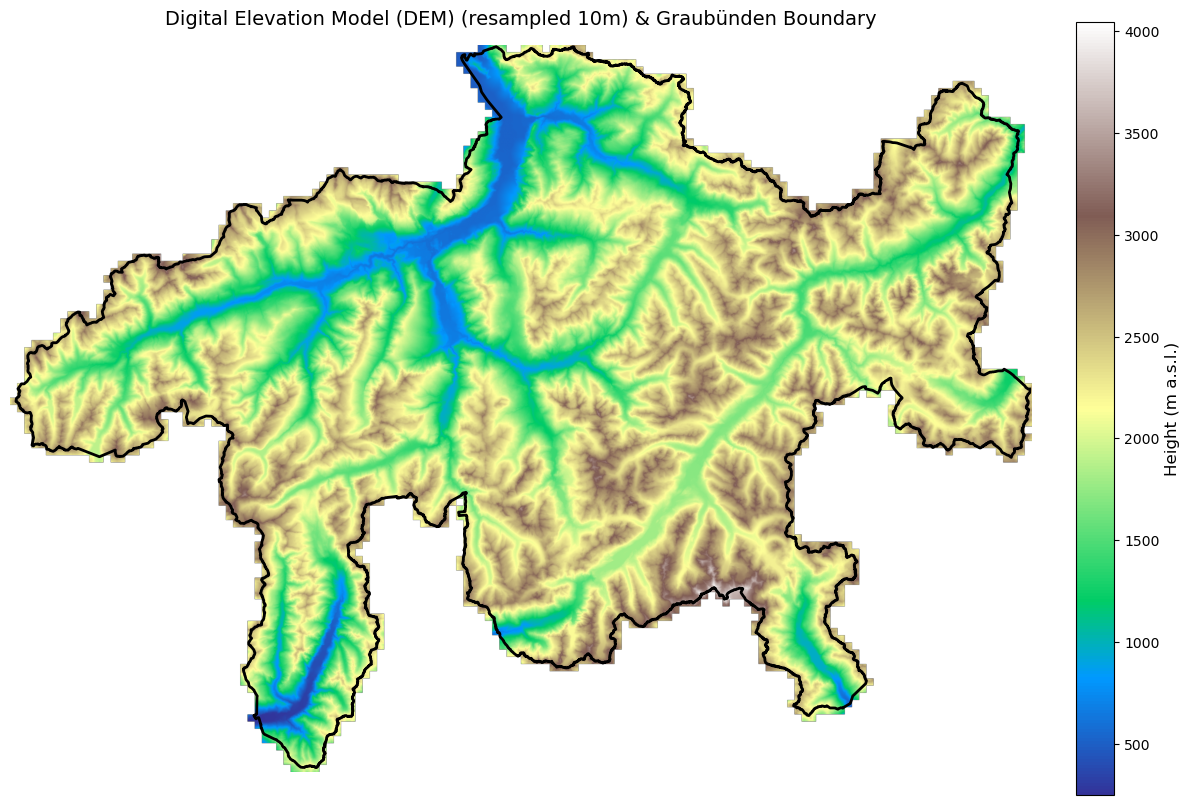

In [17]:
# We verify that all datasets share the same Coordinate Reference System (CRS). 
# For Switzerland, this must be EPSG:2056 (LV95).

# 4.1 Load Raster Data (DEM)
def inspect_raster(path, name):
    if not path.exists():
        print(f"⚠️ {name} not found.")
        return None
        
    src = rasterio.open(path)
    print(f"\n--- {name} ---")
    print(f"Resolution: {src.res}")
    print(f"Shape: {src.shape}")
    print(f"CRS: {src.crs}")
    print(f"Bounds: {src.bounds}")
    return src

dem_src = inspect_raster(PATHS["dem"], "Digital Elevation Model (DEM)")

# 4.2 Load Vector Data (Study Area)
# We only load the boundaries for now to check the extent. 
print("\nLoading Cantonal Boundaries...")

try:
    # Layer name might vary, check GPKG info if error. Common names: 'TLM_KANTONSGEBIET' or 'BOUNDARIES'
    gdf_bounds = gpd.read_file(PATHS["boundaries"], layer='TLM_KANTONSGEBIET') 
    
    print(f"Columns in Boundaries: {gdf_bounds.columns}")

    # Filter for Graubünden
    # Assuming standard swisstopo attributes (Look for 'Graubünden' or ID 18)
    if 'name' in gdf_bounds.columns:
        gdf_gr = gdf_bounds[gdf_bounds['name'] == 'Graubünden']
    else:
        gdf_gr = gdf_bounds # Fallback if filtering fails
        print("Warning: Could not filter for Graubünden automatically. Using full file.")

    print(f"Loaded Boundary CRS: {gdf_gr.crs}")
    
    # Simple Plot
    # gdf_gr.plot(facecolor='none', edgecolor='red')
    # plt.title("Study Area: Graubünden")
    # plt.show()

except Exception as e:
    print(f"Error loading boundaries: {e}")
    gdf_gr = None

# 4.3 Visual Check: Raster + Vector Overlay
if dem_src and gdf_gr is not None:
    print("\nVisualizing Overlay...")
    
    # Create a figure and axis with a specific size
    fig, ax = plt.subplots(figsize=(12, 10))

    # 1. Prepare Raster Data
    # Read the data to a numpy array (band 1)
    dem_data = dem_src.read(1)
    
    # Mask "NoData" values (usually -9999) so they don't mess up the colors
    # If the nodata attribute is set in the TIF, we use it.
    if dem_src.nodata is not None:
        dem_data = np.ma.masked_where(dem_data == dem_src.nodata, dem_data)
    
    # Get the extent (left, right, bottom, top) to map pixels to map coordinates
    extent = plotting_extent(dem_src)

    # 2. Plot Raster
    # imshow is the standard matplotlib function for displaying images/rasters
    # cmap='terrain' is perfect for elevation (blue->green->brown->white)
    im = ax.imshow(dem_data, cmap='terrain', extent=extent)

    # 3. Plot Vector (Border)
    gdf_gr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, label='Cantonal Boundary')

    # 4. Add Colorbar
    # fraction and pad help to size the bar nicely next to the map
    cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
    cbar.set_label('Height (m a.s.l.)', fontsize=12)

    # 5. Styling
    ax.set_title("Digital Elevation Model (DEM) (resampled 10m) & Graubünden Boundary", fontsize=14, pad=15)

    #no axis
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization due to missing data.")

### Land use Data (Arealstatistik and SWISSTLM3d)

In [19]:
# ------------------------------------------
# 5. Inspect Vector Data Structure (TLM & Arealstatistik)
# ------------------------------------------
print("\n" + "="*40)
print("5. INSPECTING VECTOR DATA LAYERS & ATTRIBUTES")
print("="*40)

def inspect_gpkg_structure(path, dataset_name):
    """
    Lists layers in a GPKG and inspects the first few rows of key layers.
    """
    if not path.exists():
        print(f"❌ {dataset_name} not found at {path}")
        return

    print(f"\n--- Inspecting {dataset_name} ---")
    
    try:
        # 1. List all layers
        layers = fiona.listlayers(path)
        print(f"Available Layers ({len(layers)}):")
        print(layers)
        
        # 2. Suggest layers to check based on typical names
        # We are looking for Roads ('STRASSE') and Land Cover ('BODENBEDECKUNG' or 'AREA')
        layers_to_check = []
        for l in layers:
            l_upper = l.upper()
            if 'STRASSE' in l_upper or 'ROAD' in l_upper:
                layers_to_check.append(l)
            elif 'BODENBEDECKUNG' in l_upper or 'COVER' in l_upper or 'WALD' in l_upper:
                layers_to_check.append(l)
            elif 'AREA' in l_upper or 'STANDARD' in l_upper: # Often for Arealstatistik
                layers_to_check.append(l)
        
        # If no specific layers match, check the first one
        if not layers_to_check and layers:
            layers_to_check.append(layers[0])
            
        print(f"-> Selected layers for deep inspection: {layers_to_check}")

        # 3. Inspect columns and unique values
        for layer_name in layers_to_check:
            print(f"\n   > Loading Layer: '{layer_name}' (First 100 rows for speed)...")
            # Read only a subset to be fast
            gdf = gpd.read_file(path, layer=layer_name, rows=100)
            
            print(f"     Columns: {list(gdf.columns)}")
            
            # Check for potential classification columns
            possible_class_cols = ['objektart', 'kunstbaute', 'belagsart', 'nutzung', 'AS18_4', 'AS18_17', 'AS18_72', 'Kategorie']
            found_cols = [c for c in possible_class_cols if c in gdf.columns]
            
            for col in found_cols:
                # We need to read the full file or a larger chunk to get ALL unique values, 
                # but for now let's see what's in the sample
                unique_vals = gdf[col].unique()
                print(f"     Unique values in '{col}' (sample): {unique_vals}")

    except Exception as e:
        print(f"Error inspecting {dataset_name}: {e}")

# Run Inspection for SwissTLM3D
inspect_gpkg_structure(PATHS["land_cover"], "SwissTLM3D")

# Run Inspection for Arealstatistik
inspect_gpkg_structure(PATHS["land_use"], "Arealstatistik")


5. INSPECTING VECTOR DATA LAYERS & ATTRIBUTES

--- Inspecting SwissTLM3D ---
Available Layers (40):
['tlm_strassen_aus_einfahrt', 'tlm_bb_bodenbedeckung', 'tlm_bb_einzelbaum_gebuesch', 'tlm_eo_einzelobjekt', 'tlm_oev_eisenbahn', 'tlm_gewaesser_fliessgewaesser', 'tlm_namen_flurname', 'tlm_areale_freizeitareal', 'tlm_bauten_gebaeude_footprint', 'tlm_namen_gebietsname', 'tlm_name_gelaendename', 'tlm_oev_haltestelle', 'tlm_bauten_leitung', 'tlm_bauten_mauer', 'tlm_namen_name_pkt', 'tlm_areale_nutzungsareal', 'tlm_oev_schifffahrt', 'tlm_areale_schutzgebiet', 'tlm_namen_siedlungsname', 'tlm_bauten_sportbaute_lin', 'tlm_bauten_sportbaute_ply', 'tlm_bauten_staubaute', 'tlm_gewaesser_stehendes_gewaesser', 'tlm_strassen_strasse', 'tlm_strassen_strasseninfo', 'tlm_oev_uebrige_bahn', 'tlm_bauten_verbauung', 'tlm_areale_verkehrsareal', 'tlm_bauten_verkehrsbaute_lin', 'tlm_bauten_verkehrsbaute_ply', 'tlm_bauten_versorgungsbaute_pkt', 'tlm_bb_glamos', 'tlm_bauten_leitung_stromtrasse', 'tlm_areale_nu

In "Arealstatistik" the column "AS25_72" holds the 72 categories that we might need. But according to the data documentation during 2020-2025, only data for the cantons LU, FR, AG, VD, NE, GE, JU waw captured. We will have to check this first, then if there is really no data for Graubünden for this time, we will have to use the older dataset from 2018 "AS18_72".

In [20]:
# --- 1. LOAD STUDY AREA (GRAUBÜNDEN) ---
print("--- 1. Loading Study Area Boundary ---")
try:
    # Load boundaries to use as a spatial filter (Mask)
    # We try filtering by name directly to be safe
    gdf_bounds = gpd.read_file(PATHS["boundaries"], layer='TLM_KANTONSGEBIET')
    
    # Filter for Graubünden (Case insensitive check)
    if 'NAME' in gdf_bounds.columns:
        gdf_gr = gdf_bounds[gdf_bounds['NAME'].isin(['Graubünden', 'Grigioni', 'Grischun'])]
    elif 'name' in gdf_bounds.columns:
        gdf_gr = gdf_bounds[gdf_bounds['name'].isin(['Graubünden', 'Grigioni', 'Grischun'])]
    elif 'kantonsnummer' in gdf_bounds.columns:
         gdf_gr = gdf_bounds[gdf_bounds['kantonsnummer'] == 18]
    else:
        # Fallback: Take the largest polygon if filter fails (GR is the largest canton)
        gdf_gr = gdf_bounds.loc[[gdf_bounds.area.idxmax()]]
        print("Warning: Filtering by name failed. Selected largest canton (likely GR).")

    print(f"Study Area loaded: {gdf_gr.iloc[0]['name'] if 'name' in gdf_gr.columns else 'Unknown'} (CRS: {gdf_gr.crs})")
    
except Exception as e:
    print(f"CRITICAL ERROR: Could not load boundaries. {e}")
    exit()


--- 1. Loading Study Area Boundary ---
Study Area loaded: Graubünden (CRS: EPSG:2056)


In [ ]:
# --- CHECK AREALSTATISTIK (AS25 vs AS18) ---
print("\n" + "="*40)
print("2. CHECKING AREALSTATISTIK AVAILABILITY")
print("="*40)

try:
    # We use the 'mask' parameter to ONLY load points inside Graubünden.
    # This saves huge amounts of memory and time.
    print("Querying Arealstatistik points inside Graubünden boundary...")
    
    gdf_as_sample = gpd.read_file(
        PATHS["land_use"], 
        layer='arealstatistik_all',
        mask=gdf_gr # SPATIAL FILTER
    )
    
    print(f"Loaded {len(gdf_as_sample)} sample points inside Graubünden.")
    
    # Check valid values
    # AS25_72 = Nomenklatur 2025, 72 Grundkategorien
    # AS18_72 = Nomenklatur 2018, 72 Grundkategorien
    
    cols_to_check = ['AS18_72', 'AS25_72']
    
    for col in cols_to_check:
        if col in gdf_as_sample.columns:
            # Count non-null and non-zero values (sometimes 0 or 9999 is NoData)
            valid_count = gdf_as_sample[col].dropna().count()
            unique_vals = gdf_as_sample[col].unique()
            
            print(f"\nColumn '{col}':")
            print(f"  - Valid Rows: {valid_count} / {len(gdf_as_sample)}")
            print(f"  - Unique Values (Sample): {unique_vals[:10]}...")
            
            if valid_count < len(gdf_as_sample) * 0.1:
                print(f"  ⚠️ WARNING: '{col}' seems mostly empty for Graubünden!")
            else:
                print(f"  ✅ '{col}' seems usable.")
        else:
            print(f"  ❌ Column '{col}' not found in dataset.")

except Exception as e:
    print(f"Error checking Arealstatistik: {e}")


2. CHECKING AREALSTATISTIK AVAILABILITY
Querying Arealstatistik points inside Graubünden boundary...
Loaded 710517 sample points inside Graubünden.

Column 'AS18_72':
  - Valid Rows: 710517 / 710517
  - Unique Values (Sample): [72 70 69 46 48 65 47 67 62 64]...
  ✅ 'AS18_72' seems usable.

Column 'AS25_72':
  - Valid Rows: 0 / 710517
  - Unique Values (Sample): [nan]...
  ⚠️ WARNING: 'AS25_72' seems mostly empty for Graubünden!


In [22]:
# --- 3. INSPECT SWISSTLM3D LAYERS ---
print("\n" + "="*40)
print("3. INSPECTING RELEVANT SWISSTLM3D LAYERS")
print("="*40)

def analyze_tlm_layer(layer_name, attributes_of_interest):
    print(f"\n--- Analyzing Layer: {layer_name} ---")
    try:
        # Load a chunk (first 5000 rows) to get a good distribution of types
        # We don't use the mask here to speed up purely attribute inspection
        gdf = gpd.read_file(PATHS["land_cover"], layer=layer_name, rows=5000)
        
        for attr in attributes_of_interest:
            if attr in gdf.columns:
                counts = gdf[attr].value_counts().head(15)
                print(f"\n> Top 15 values in '{attr}':")
                print(counts)
            else:
                print(f"> Attribute '{attr}' not found.")
                
    except Exception as e:
        print(f"Error reading layer {layer_name}: {e}")

# A. ROADS (Störung)
# 'objektart': Autobahn vs Strasse
# 'kunstbaute': Tunnel (WICHTIG!) vs Brücke
analyze_tlm_layer('tlm_strassen_strasse', ['objektart', 'kunstbaute', 'belagsart'])

# B. LAND COVER (Wald, Fels)
# 'objektart': Wald, Fels, Gletscher, etc.
analyze_tlm_layer('tlm_bb_bodenbedeckung', ['objektart'])

# C. RAILWAYS (Störung)
analyze_tlm_layer('tlm_oev_eisenbahn', ['objektart', 'objektart_spez'])

# D. BUILDINGS (Alternative für Siedlung)
# Just to see what classifications we have
analyze_tlm_layer('tlm_bauten_gebaeude_footprint', ['objektart', 'objektname'])

print("\n\n--- RECOMMENDATION ---")
print("Check the output above:")
print("1. If AS25_72 is empty/incomplete -> Change config to use AS18_72.")
print("2. Note down the exact 'objektart' names for the filter lists (e.g., is it 'Wald' or 'Wald offen'?).")


3. INSPECTING RELEVANT SWISSTLM3D LAYERS

--- Analyzing Layer: tlm_strassen_strasse ---

> Top 15 values in 'objektart':
objektart
Autobahn       4208
Autostrasse     781
Einfahrt          6
Ausfahrt          3
Zufahrt           2
Name: count, dtype: int64

> Top 15 values in 'kunstbaute':
kunstbaute
Keine                  3340
Bruecke                1187
Tunnel                  369
Galerie                  65
Unterfuehrung            24
in/auf Gebaeude           8
Bruecke mit Galerie       5
Gedeckte Bruecke          2
Name: count, dtype: int64

> Top 15 values in 'belagsart':
belagsart
Hart    5000
Name: count, dtype: int64

--- Analyzing Layer: tlm_bb_bodenbedeckung ---

> Top 15 values in 'objektart':
objektart
Wald                    2782
Stehende Gewaesser       725
Fels                     636
Feuchtgebiet             317
Gehoelzflaeche           308
Lockergestein            139
Lockergestein locker      26
Fels locker               21
Fliessgewaesser           21
Gebueschwald 